# **Importing Libraries**

In [1]:
import os
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

print('Libraries Loaded')

2024-08-16 00:45:10.654108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 00:45:10.654341: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 00:45:10.812391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Libraries Loaded


# **Data Loading & Preprocessing**

In [2]:
def loading_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [3]:
data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/train'
train_df = loading_data(data_dir)

train_df

,filepaths,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
...,...,...
2632,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2633,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2634,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2635,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant


In [4]:
train_df.sample(10)

,filepaths,labels
1336,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1521,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
1142,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1009,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2519,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
2144,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
1668,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
1503,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
27,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
625,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign


In [5]:
data_dir = '/kaggle/input/skin-cancer-malignant-vs-benign/test'
testing_df = loading_data(data_dir)

testing_df

,filepaths,labels
0,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
1,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
2,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
3,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
4,/kaggle/input/skin-cancer-malignant-vs-benign/...,benign
...,...,...
655,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
656,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
657,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant
658,/kaggle/input/skin-cancer-malignant-vs-benign/...,malignant


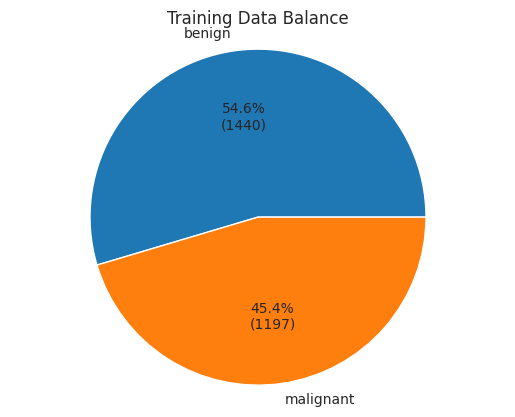

In [6]:
data_balance = train_df.labels.value_counts()

def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.00))
    return "{:.1f}%\n({:d})".format(pct, val)

plt.pie(data_balance, 
        labels = data_balance.index, 
        autopct = custom_autopct)
plt.title('Training Data Balance')
plt.axis('equal')
plt.show()

***Data is Balanced***

In [7]:
valid_df, test_df = train_test_split(testing_df, train_size = 0.5, 
                                     shuffle = True, random_state = 42)

In [8]:
batch_size = 8
img_size = (224,224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepaths', 
                                       y_col= 'labels', target_size= img_size, 
                                       class_mode= 'categorical', color_mode= 'rgb', 
                                       shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepaths', 
                                       y_col= 'labels', target_size= img_size, 
                                       class_mode= 'categorical', color_mode= 'rgb', 
                                       shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepaths', 
                                      y_col= 'labels', target_size= img_size, 
                                      class_mode= 'categorical', color_mode= 'rgb', 
                                      shuffle= False, batch_size= batch_size)

Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


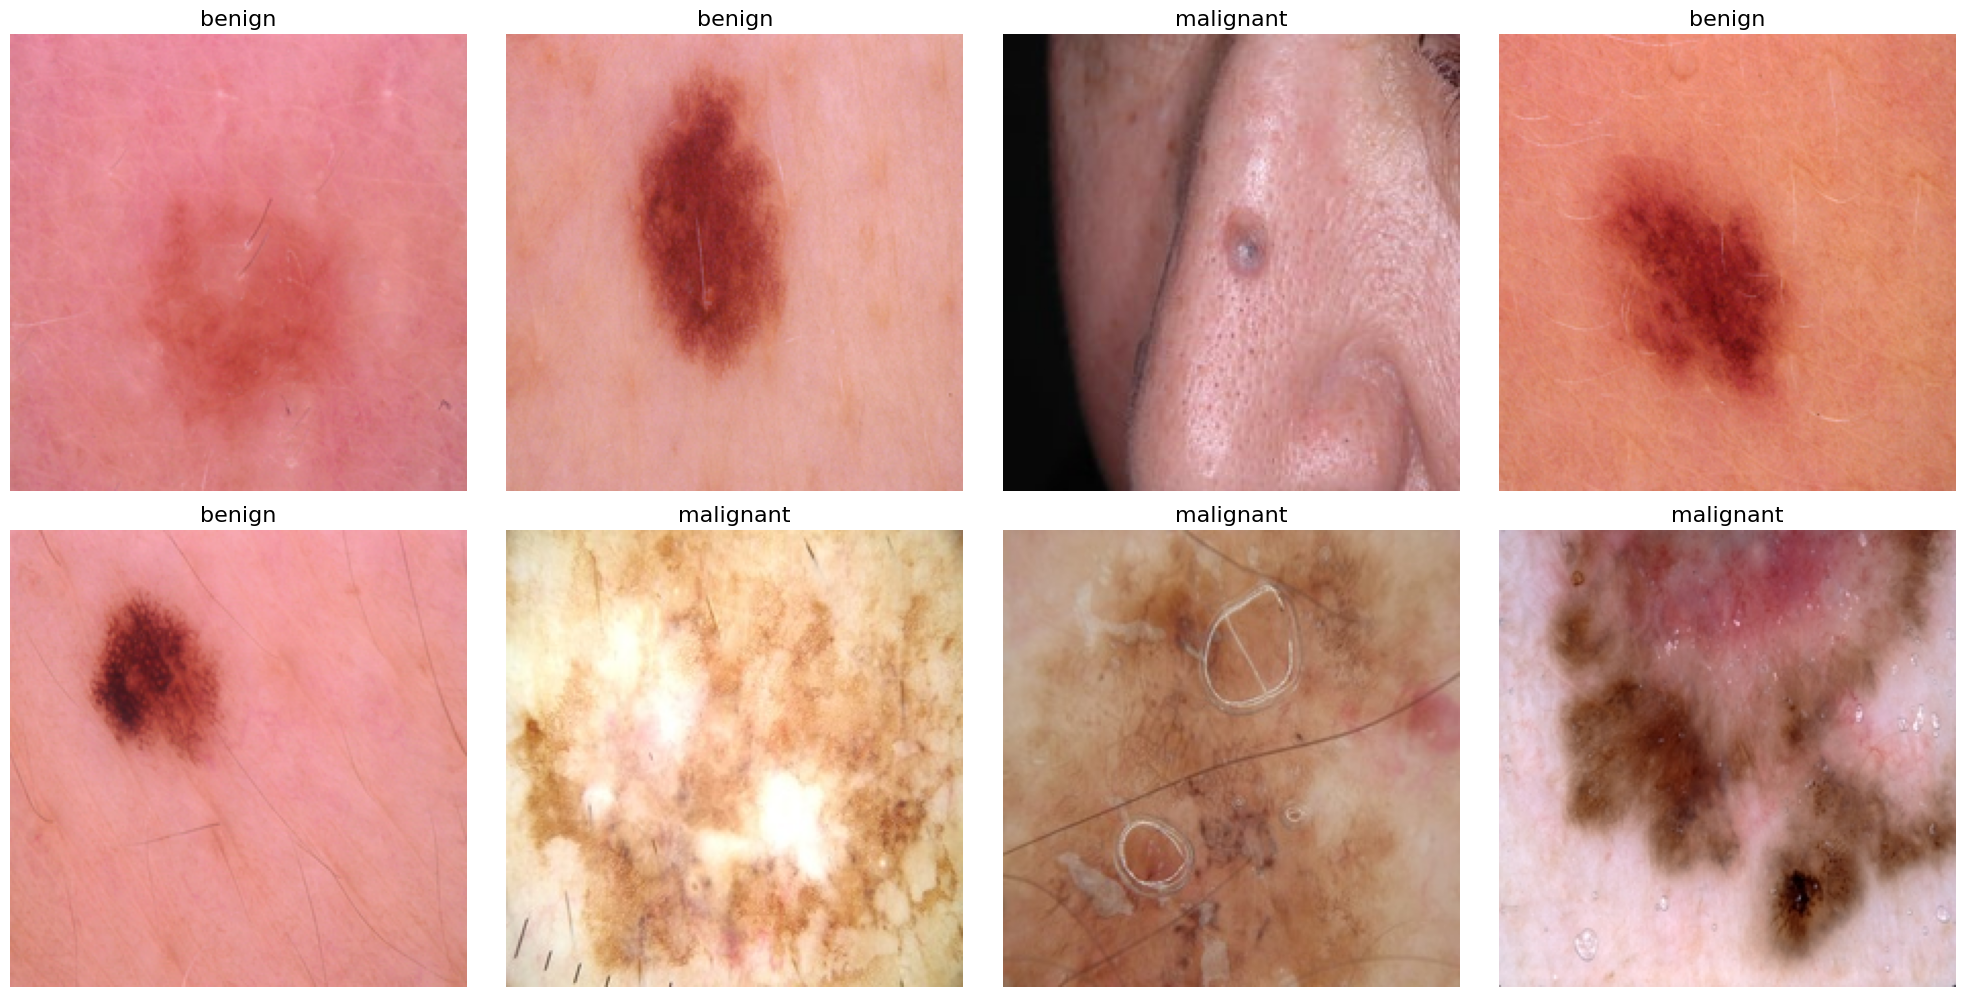

In [9]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())    
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()
    

def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])
    

def plot_confusion_matrix(model, test_gen):
    # Get Predictions
    preds = model.predict(test_gen)  
    y_pred = np.argmax(preds, axis=1)
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()

In [11]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys())) 

In [12]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape = img_shape, pooling= None)

for layer in base_model.layers:
    if 'conv5_block3' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.5)(x) 
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x) 

ResNet50_model = Model(inputs = base_model.input, outputs = predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
for layer in ResNet50_model.layers:
    print(layer.name, layer.trainable)

input_layer False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2

In [14]:
ResNet50_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

ResNet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,862,370 (91.03 MB)

 Trainable params: 4,736,226 (18.07 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

In [15]:
epochs = 15

ResNet50_history = ResNet50_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 290s 845ms/step - accuracy: 0.7297 - loss: 0.5483 - val_accuracy: 0.5030 - val_loss: 0.6930
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 277s 838ms/step - accuracy: 0.7841 - loss: 0.4492 - val_accuracy: 0.6273 - val_loss: 0.6887
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 284s 859ms/step - accuracy: 0.7960 - loss: 0.4231 - val_accuracy: 0.6273 - val_loss: 0.5913
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 313s 834ms/step - accuracy: 0.8064 - loss: 0.4073 - val_accuracy: 0.8091 - val_loss: 0.4386
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 276s 836ms/step - accuracy: 0.8280 - loss: 0.3840 - val_accuracy: 0.6909 - val_loss: 0.5648
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 276s 836ms/step - accuracy: 0.8251 - loss: 0.3848 - val_accuracy: 0.8152 - val_loss: 0.4068
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 281s 852ms/step - accuracy: 0.8107 - loss: 0.3830 - val_accuracy: 0.5879 - val_loss: 1.3697
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 277s 841ms/step - accuracy: 0.8065 -

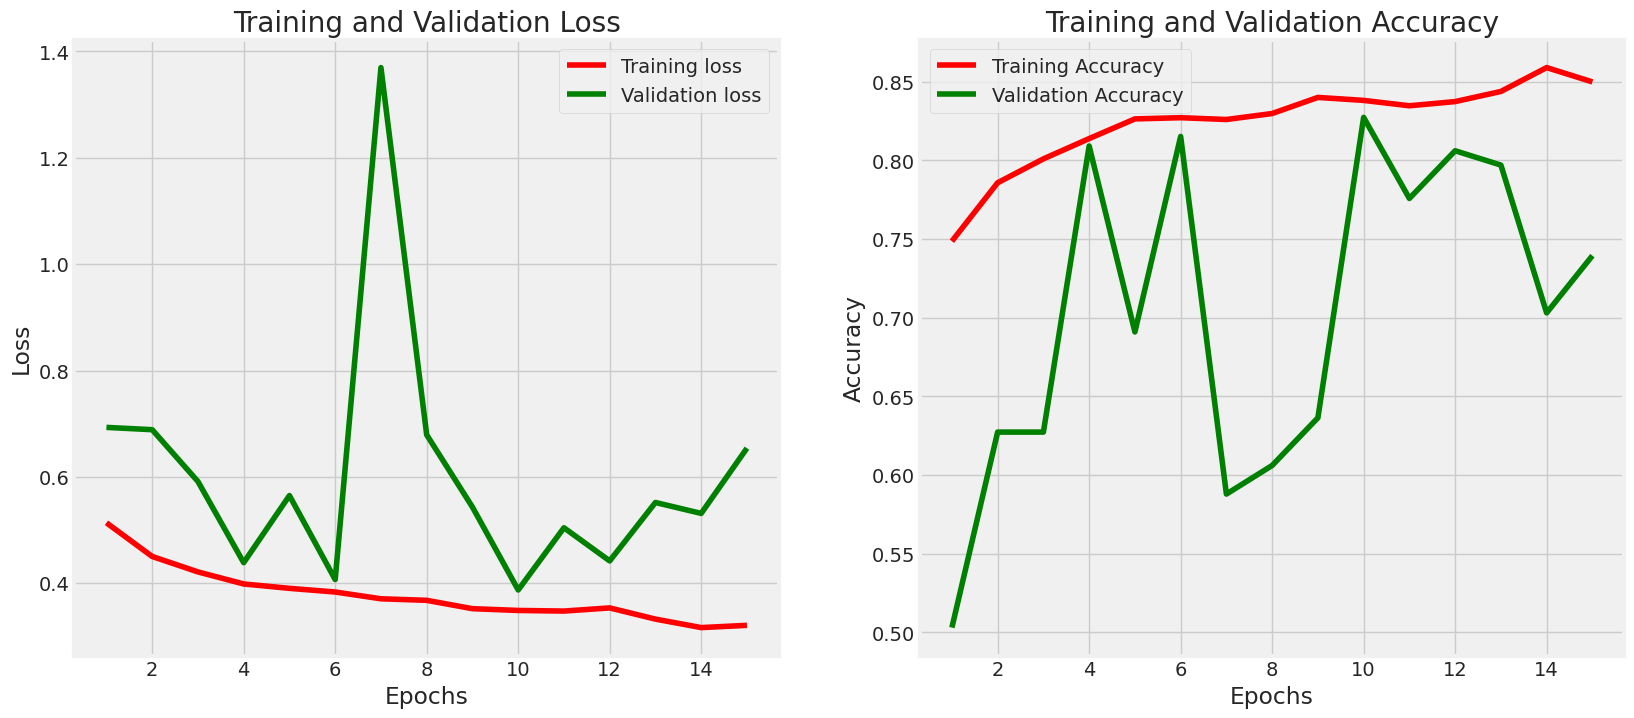

In [16]:
model_performance(ResNet50_history, epochs)

In [17]:
model_evaluation(ResNet50_model)

330/330 ━━━━━━━━━━━━━━━━━━━━ 214s 649ms/step - accuracy: 0.7340 - loss: 0.5982
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 631ms/step - accuracy: 0.7716 - loss: 0.6243
42/42 ━━━━━━━━━━━━━━━━━━━━ 27s 640ms/step - accuracy: 0.7142 - loss: 0.7813
Train Loss:  0.5869080424308777
Train Accuracy:  0.7330299615859985
--------------------
Validation Loss:  0.6539318561553955
Validation Accuracy:  0.739393949508667
--------------------
Test Loss:  0.8104719519615173
Test Accuracy:  0.7030302882194519


42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 689ms/step


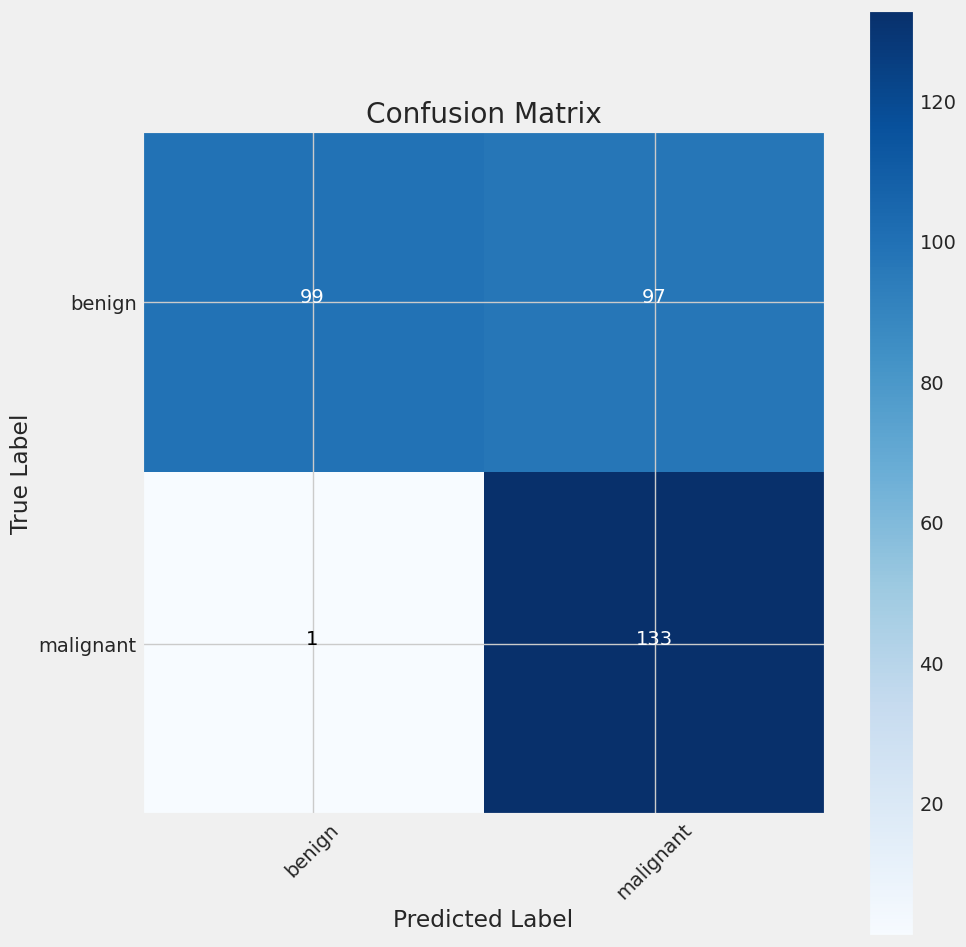

In [18]:
plot_confusion_matrix(ResNet50_model, test_gen)

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

for layer in base_model.layers[:15]:
    layer.trainable = False
    

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)

VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten True
dense_3 True
dropout_1 True
dense_4 True
dense_5 True
dense_6 True
dense_7 True


In [21]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,145,762 (57.78 MB)

 Trainable params: 7,510,498 (28.65 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [22]:
epochs = 15

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 1001s 3s/step - accuracy: 0.7509 - loss: 0.5069 - val_accuracy: 0.8818 - val_loss: 0.3554
Epoch 2/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 994s 3s/step - accuracy: 0.8532 - loss: 0.3344 - val_accuracy: 0.8424 - val_loss: 0.3075
Epoch 3/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 1034s 3s/step - accuracy: 0.8553 - loss: 0.3040 - val_accuracy: 0.8273 - val_loss: 0.4148
Epoch 4/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 1051s 3s/step - accuracy: 0.8729 - loss: 0.2676 - val_accuracy: 0.8636 - val_loss: 0.3337
Epoch 5/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 980s 3s/step - accuracy: 0.8997 - loss: 0.2172 - val_accuracy: 0.8455 - val_loss: 0.3466
Epoch 6/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 979s 3s/step - accuracy: 0.9239 - loss: 0.1922 - val_accuracy: 0.8818 - val_loss: 0.3231
Epoch 7/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 984s 3s/step - accuracy: 0.9493 - loss: 0.1331 - val_accuracy: 0.8606 - val_loss: 0.3487
Epoch 8/15
330/330 ━━━━━━━━━━━━━━━━━━━━ 992s 3s/step - accuracy: 0.9619 - loss: 0.1087 - val_a

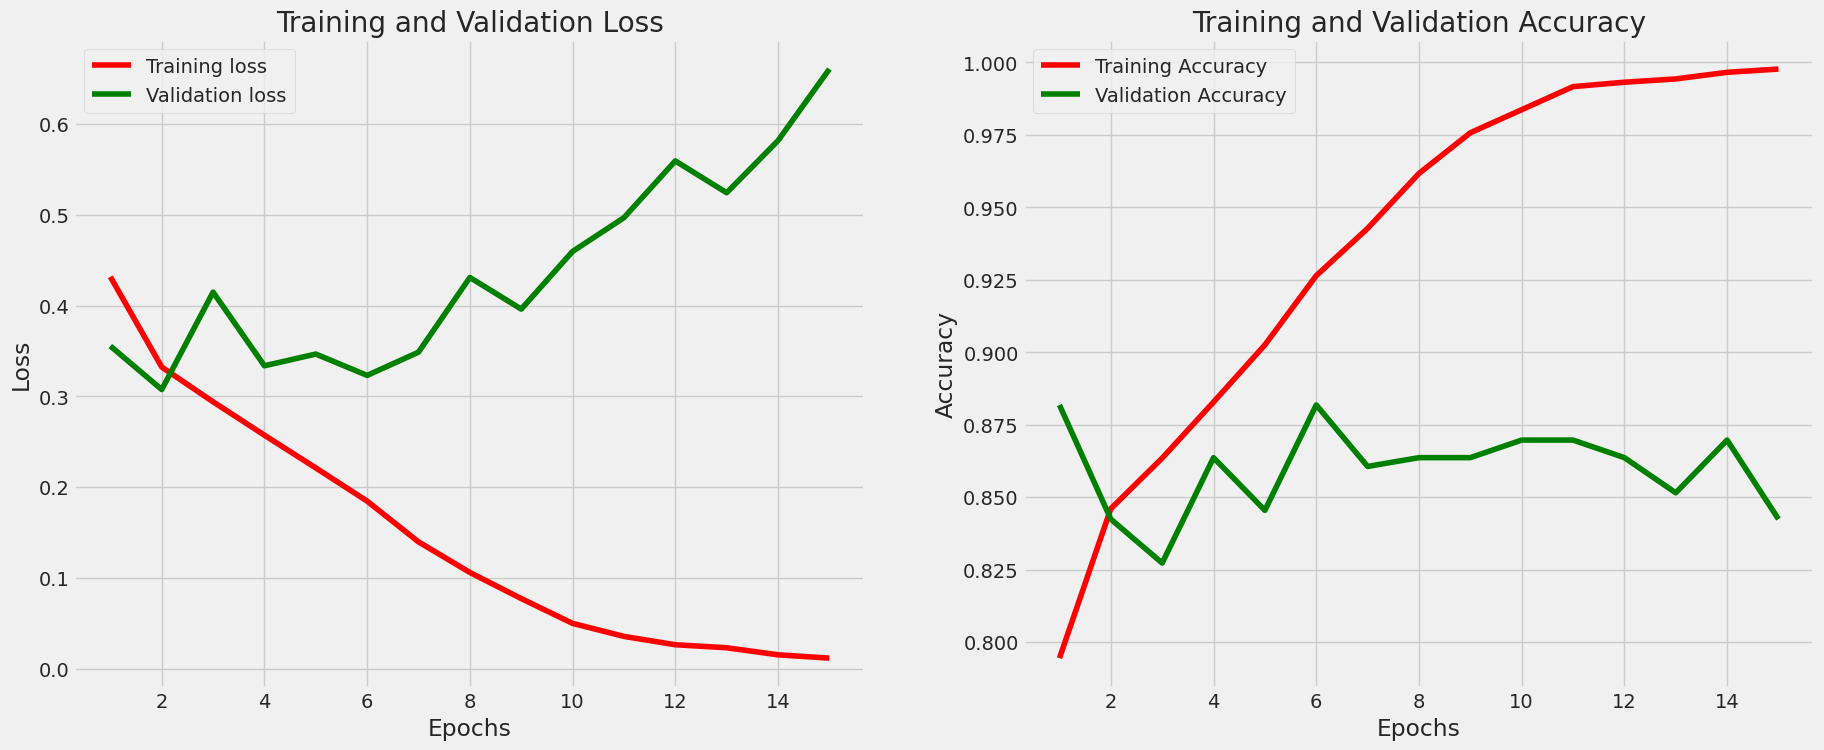

In [23]:
model_performance(VGG16_history, epochs)

In [24]:
model_evaluation(VGG16_model)

330/330 ━━━━━━━━━━━━━━━━━━━━ 736s 2s/step - accuracy: 0.9987 - loss: 0.0109
42/42 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8635 - loss: 0.5860
42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8366 - loss: 0.6467
Train Loss:  0.008644786663353443
Train Accuracy:  0.9988623261451721
--------------------
Validation Loss:  0.6605945229530334
Validation Accuracy:  0.842424213886261
--------------------
Test Loss:  0.5224950909614563
Test Accuracy:  0.8515151739120483


42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step


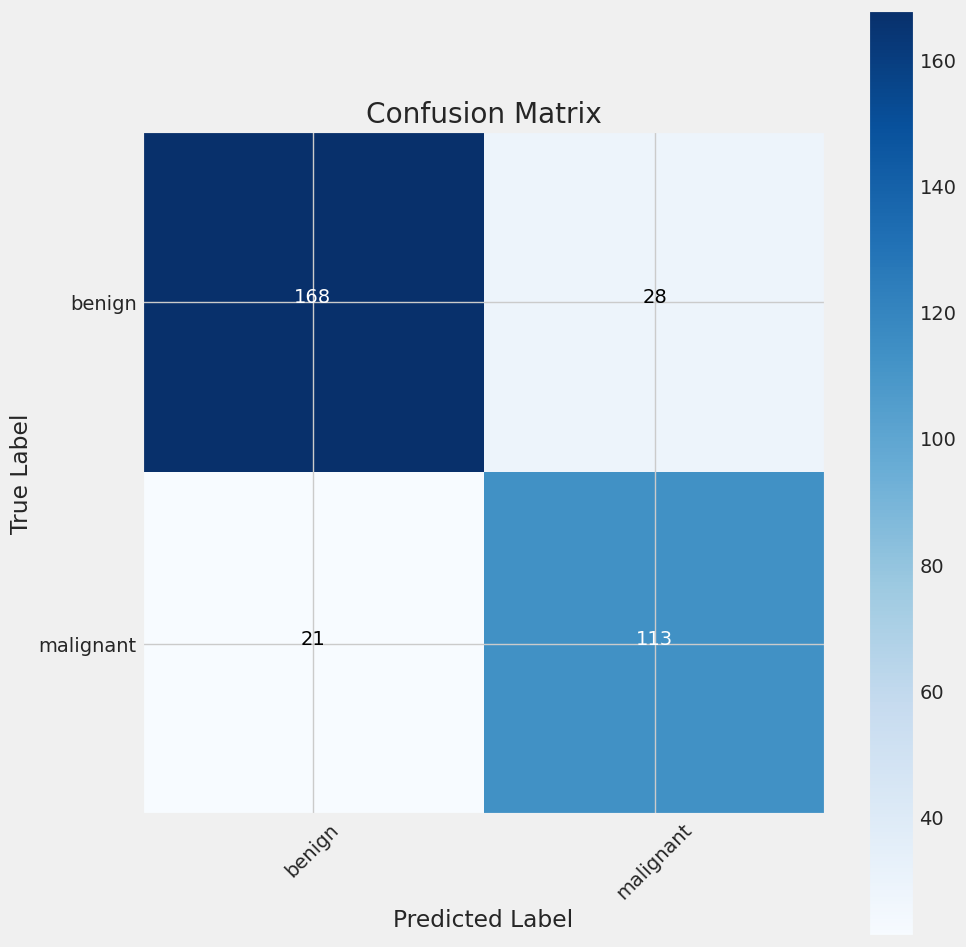

In [25]:
plot_confusion_matrix(VGG16_model, test_gen)